<a href="https://colab.research.google.com/github/creepereye1204/HomeWork/blob/main/20230406/%EC%A0%84%EC%9D%B4%ED%95%99%EC%8A%B5_lr%3D0_00001-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:

from sklearn.model_selection import train_test_split

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
files.upload()

In [11]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c plant-pathology-2021-fgvc8

100% 14.9G/14.9G [02:20<00:00, 171MB/s]
100% 14.9G/14.9G [02:20<00:00, 113MB/s]


In [7]:
import os
os.mkdir('/content/train')
os.mkdir('/content/test')
os.mkdir('/content/eval')

In [16]:
!unzip /content/plant-pathology-2021-fgvc8.zip -d /content/

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: /content/train_images/e00c97b2de4749ce.jpg  
  inflating: /content/train_images/e00df890cfe62736.jpg  
  inflating: /content/train_images/e00ed0bf43a87f25.jpg  
  inflating: /content/train_images/e00f759d65d52887.jpg  
  inflating: /content/train_images/e00f934d9e50ad5b.jpg  
  inflating: /content/train_images/e00fce341cb63da5.jpg  
  inflating: /content/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /content/train_images/e01112939f783fec.jpg  
  inflating: /content/train_images/e01592da4d71b8be.jpg  
  inflating: /content/train_images/e0189acaf8cf80fd.jpg  
  inflating: /content/train_images/e0189e4999bdd0fa.jpg  
  inflating: /content/train_images/e01ae16d4a759cb5.jpg  
  inflating: /content/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /content/train_images/e01e42d90c66f3f3.jpg  
  inflating: /content/train_images/e01e870bec65f40f.jpg  
  inflating: /content/train_images/e01f17e0187fb80f.jpg  
  inflating: /content/train_images/e

In [17]:
import pandas as pd

In [18]:
train=pd.read_csv('/content/train.csv')

In [19]:
for dir in ['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']:
  os.makedirs('/content/train/'+dir)
  os.makedirs('/content/test/'+dir)
  os.makedirs('/content/eval/'+dir)

In [20]:
new=pd.DataFrame(columns=['image','labels'])
for idx,(image,label) in enumerate(train.values):
  n=len(label.split())
  if n!=1:
    cols= ['image','labels']	
    
    add_row = [[image,'complex']]	

    row_df = pd.DataFrame(data = add_row, columns = cols)	
                          
    new = pd.concat([new, row_df], ignore_index = True)
    train.drop(labels=idx,axis=0,inplace=True)

In [21]:
train=pd.concat([new,train],ignore_index=True)

In [22]:
train,other=train_test_split(train,  train_size= 0.6, shuffle= True)
test,eval=train_test_split(other,  train_size= 0.5, shuffle= True)

In [23]:
import shutil
def move(data,where):
  path='/content/train_images/'
  for name,label in data.values:
    if os.path.exists(path+name):
        shutil.move(path+name,"/content/"+where+"/"+label+'/'+name)

In [24]:
for key,value in {'train':train,'test':test,'eval':eval}.items():
  move(value,key)

In [25]:
train['labels'].isnull().sum()

0

In [26]:
train['labels'].value_counts()

scab                  2919
healthy               2780
frog_eye_leaf_spot    1930
complex               1772
rust                  1099
powdery_mildew         679
Name: labels, dtype: int64

In [27]:
import matplotlib.pyplot as plt


<Axes: >

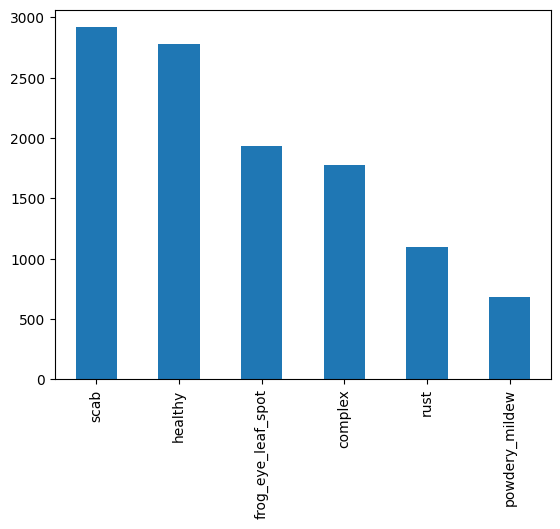

In [28]:
train['labels'].value_counts().plot(kind='bar')

In [29]:
len(train)

11179

In [30]:
test

,image,labels
7355,ae92c4a0cef1c2f3.jpg,frog_eye_leaf_spot
5381,a22d322b3df799c0.jpg,scab
5994,a694906969e47ef2.jpg,frog_eye_leaf_spot
11035,c888c0f3d322f36f.jpg,scab
15143,e8bd8ac4d982dd83.jpg,complex
...,...,...
9433,be82831fe8c471c7.jpg,rust
316,a5ce4a5e45957ea0.jpg,complex
18469,ff3d8130915bd249.jpg,frog_eye_leaf_spot
5550,a464069ab6b56776.jpg,frog_eye_leaf_spot


In [31]:
eval

,image,labels
8764,b88497add352d855.jpg,scab
963,deab6c70f422cc31.jpg,complex
17485,f9361bc7b1fc8220.jpg,scab
10118,c1dc6b39701eca8e.jpg,powdery_mildew
6325,a8f6a1829f9298f6.jpg,frog_eye_leaf_spot
...,...,...
1873,83b998ef75212336.jpg,scab
7079,ad352a859eab01eb.jpg,healthy
5092,a0acbcb49c5c172f.jpg,frog_eye_leaf_spot
3962,95aa53c32965a0ef.jpg,healthy


In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

In [33]:
nc = 3
nz = 100
ngf = 64
ndf = 64
num_epochs = 5
lr = 0.0002
beta1 = 0.5
ngpu = 1

In [34]:
if torch.cuda.is_available():
  device=torch.device('cuda')

trans_train=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_test=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])
trans_eval=transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
])

train_data = datasets.ImageFolder(root='/content/train', 
                                    transform=trans_train,
                                   )
train_loader=DataLoader(dataset=train_data,batch_size=32,shuffle=True,drop_last=True,)

test_data = datasets.ImageFolder(root='/content/test', 
                                    transform=trans_test
                                   )
test_loader=DataLoader(dataset=test_data,batch_size=32,shuffle=True,drop_last=True)

eval_data = datasets.ImageFolder(root='/content/eval', 
                                    transform=trans_eval
                                   )
eval_loader=DataLoader(dataset=eval_data,batch_size=32,shuffle=True,drop_last=True)

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils
real_batch=next(iter(train_loader))

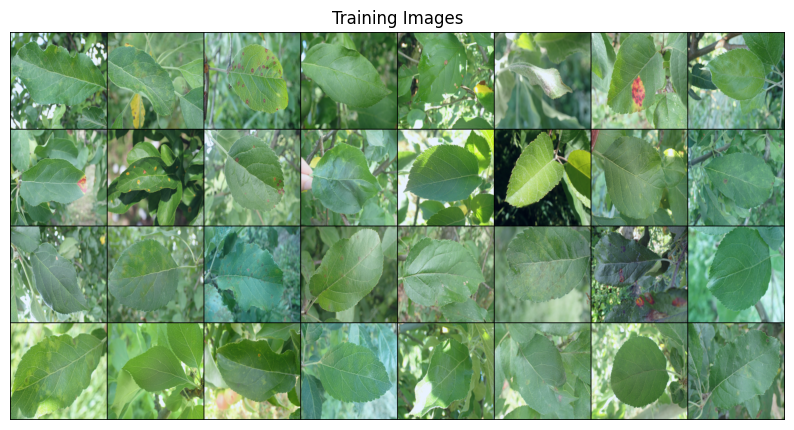

In [36]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.title('Training Images')
plt.imshow(np.transpose(vutils.make_grid(real_batch[0],padding=2,normalize=True).cpu(),(1,2,0)));

In [37]:
from torchvision import models
import torch.optim as optim

In [38]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 6)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optim = optim.Adam(model_ft.parameters(), lr=0.00001)


/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 90.0MB/s]


In [43]:
model_ft.load_state_dict(torch.load('/content/drive/MyDrive/Plant_Pathology_lr_changed_new.pth'))

<All keys matched successfully>

In [40]:
def train(R,optim,cri):
 
  for epoch in range(3):
    for index,sample in enumerate(train_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      optim.zero_grad()
      cost.backward()
      optim.step()
      if index%10==0:
        print('epoch {} , cost: {:.4f}'.format(epoch,cost.item()))
        test(R,cri)
        R.train()
      torch.save(R.state_dict(),'/content/drive/MyDrive/Plant_Pathology_lr_changed_new.pth')

In [41]:
def test(R,cri):
  R.eval()
  correct=0
  loss_avg=0
  with torch.no_grad():
    for index,sample in enumerate(test_loader):
      x,y=sample
      X=x.to(device)
      Y=y.to(device)
      out=R(X)
      cost=criterion(out,Y)
      loss_avg+=cost.item()
      prediction=out.max(1,keepdim=True)[1]
      correct+=prediction.eq(Y.view_as(prediction)).sum().item()
      


  test_accuracy=100*correct/len(test_loader.dataset)
  loss_avg/=len(test_loader.dataset)
  print('accurate: {:.2f}%'.format(test_accuracy))
  print('loss_avg:',loss_avg)

In [42]:
train(model_ft,optim,criterion)

epoch 0 , cost: 0.4693
accurate: 87.22%
loss_avg: 0.01316929118676782
epoch 0 , cost: 0.1796
accurate: 87.39%
loss_avg: 0.012719967279041318
epoch 0 , cost: 0.3124
accurate: 87.25%
loss_avg: 0.01276926634312316
epoch 0 , cost: 0.5218


KeyboardInterrupt: ignored